# Graph Community Detection 

We divide the community graph into different clusters (communities). 

The different options of the community detection algorithms are: 

* louvain: 
* greedy_modularity: 
* asyn_lpa: 
* label_propagation:

In [2]:
import pickle 
import networkx as nx 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from networkx.algorithms import community
import community as community_louvain
#import pymongo
import pandas as pd 
import torch

In [4]:
# load community graph

dataset = 'wich' # 'davidson'
if dataset == 'waseem':
    graph = torch.load('../../data/waseem/community_graph_new.pt')
elif dataset == 'davidson':
    graph = torch.load('../../data/davidson/community_graph_new.pt')
elif dataset == 'wich':
    graph = torch.load('../../data/wich/community_graph.pt')    

In [5]:
node_data = dict(graph.nodes(data=True))
features_df = pd.DataFrame.from_dict(node_data, orient='index')

In [6]:
node_data

{'1006326': {'othercount': 39, 'offensivecount': 61, 'user_class': 1},
 '1019101': {'othercount': 79, 'offensivecount': 20, 'user_class': 1},
 '1001632': {'othercount': 92, 'offensivecount': 6, 'user_class': 1},
 '1015213': {'othercount': 90, 'offensivecount': 3, 'user_class': 1},
 '1019121': {'othercount': 98, 'offensivecount': 0, 'user_class': 0},
 '1003532': {'othercount': 99, 'offensivecount': 1, 'user_class': 0},
 '1004632': {'othercount': 88, 'offensivecount': 11, 'user_class': 1},
 '1004332': {'othercount': 91, 'offensivecount': 7, 'user_class': 1},
 '1008885': {'othercount': 83, 'offensivecount': 13, 'user_class': 1},
 '1008306': {'othercount': 88, 'offensivecount': 12, 'user_class': 1},
 '1016427': {'othercount': 87, 'offensivecount': 12, 'user_class': 1},
 '1017617': {'othercount': 77, 'offensivecount': 16, 'user_class': 1},
 '1009218': {'othercount': 93, 'offensivecount': 7, 'user_class': 1},
 '1005369': {'othercount': 97, 'offensivecount': 3, 'user_class': 1},
 '1001613': {

In [99]:
features_df[features_df.index==98605029] # only to check if user class labelling is correct

,racism,sexism,neither,user_class
98605029,0,0,1,2


In [7]:
community_detection_algo = "louvain" # "greedy_modularity"

In [8]:
community_detection_method = {
    "greedy_modularity": community.greedy_modularity_communities,
    "asyn_lpa": community.asyn_lpa_communities,
    "label_propagation": community.label_propagation_communities,
}

In [9]:
#def plot_community(graph, community):
if community_detection_algo == "louvain":
    partition = community_louvain.best_partition(graph)
    clusters = max(partition.values()) + 1

    print(f"Partitioned graph into {clusters} communities")
    
else: 
    communities_generator = community_detection_method[community_detection_algo](graph)
    communities = [c for c in communities_generator]
    
    partition = {} #node2community
    for i, nodes in enumerate(communities):
        for node in nodes: 
            partition[node] = i
    

Partitioned graph into 26 communities


In [10]:
clusters = max(partition.values()) + 1 
print(f"Partitioned graph into {clusters} communities")

Partitioned graph into 26 communities


In [11]:
cluster_dict = {}
for c in range(clusters):
    cluster_dict[c] = []

if isinstance(partition, dict):
    for node, cluster in partition.items():
        cluster_dict[cluster].append(node)


In [12]:
graph_communities = community_louvain.induced_graph(partition, graph)

list_communities = []
community_labels = {}
users_in_communities = 0 
communities_without_connection = 0 
single_node_communities = 0 
cluster_sizes = [len(nodes) for c, nodes in cluster_dict.items()]
for c, nodes in cluster_dict.items():
    connected_clusters = len(graph_communities.edges(c))
    if len(nodes) > 1 and connected_clusters > 1: 
        list_communities.append(c) 
        community_labels[c] = f"C{c} ({len(nodes)})"
        users_in_communities += len(nodes)
    if len(nodes) == 1: 
        single_node_communities +=1 
    if connected_clusters == 1: 
        communities_without_connection += 1


In [13]:
print("Single-node communities: ", single_node_communities)
print("Communities without connections: ", communities_without_connection)
print("Users in connected communities: ", users_in_communities)
print("Average number of users in communities (except single-node communities): ",round(users_in_communities/(clusters - single_node_communities),2))

Single-node communities:  1
Communities without connections:  0
Users in connected communities:  44943
Average number of users in communities (except single-node communities):  1797.72


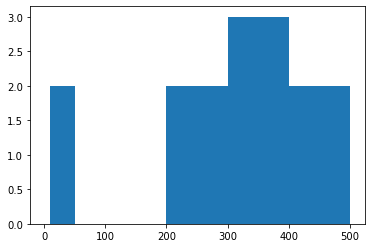

In [14]:
plt.hist(cluster_sizes, bins=[2,3,4,10,50,100,200,300,400, 500]) #, density=True)
plt.show()

In [15]:
# pos_c = nx.spring_layout(graph_communities)

In [16]:
subgraph = graph_communities.subgraph(list_communities).copy()
pos_c1 = nx.kamada_kawai_layout(subgraph)
subgraph.remove_edges_from(nx.selfloop_edges(subgraph))

In [17]:
print("Connected communities: ", len(list_communities))
print("Edges: ", subgraph.number_of_edges())

Connected communities:  25
Edges:  224


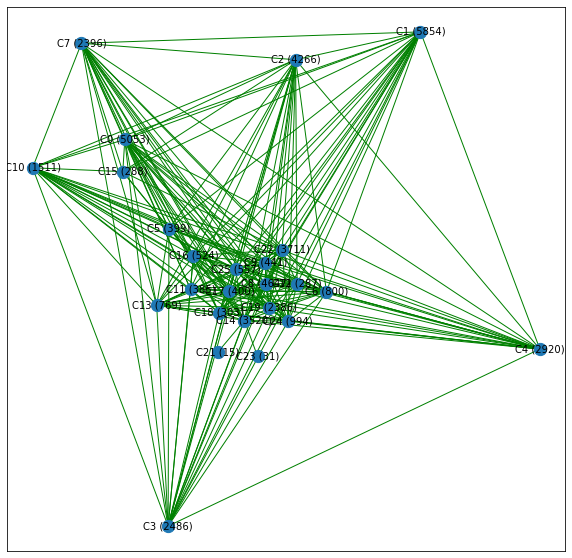

In [18]:
plt.figure(1, figsize=(10,10)) 
nx.draw_networkx_nodes(subgraph, pos_c1, list_communities, node_size=150)
nx.draw_networkx_edges(subgraph, pos_c1, edge_color='green')
nx.draw_networkx_labels(subgraph, pos_c1, community_labels, font_size=10)

plt.show()

In [19]:
# Load node labels
node_data = dict(graph.nodes(data=True))
node_labels = pd.DataFrame.from_dict(node_data, orient='index')['user_class']

In [20]:
cluster_dict_main_class = {}
for k in cluster_dict.keys():
    cluster_nodes = cluster_dict[k]
    #print(cluster_nodes)
    main_class = node_labels[cluster_nodes].value_counts().head(1).index[0]
    cluster_dict_main_class[k] = main_class

In [114]:
cluster_dict_main_class.get(0) #check

2

In [115]:
partition.get(105447442) #check

8

In [21]:
node_labels.value_counts().head() #check

0    23807
1    21137
Name: user_class, dtype: int64

In [25]:
all_users_dict = dict()
#user_community_dict = {"own_community":[], "communities":[], "related_users":[]}
mode = "undirectional"

for i, user_id in enumerate(partition.keys()):
    if i % 1000 == 0:
        print(i)
    
    user_community_dict = {"own_community":[], "main_class_of_community":[], "communities":[], "related_users":[]}
    user_community = partition.get(user_id)
    #user_community_dict["user_id"].append(user_id)
    user_community_dict["own_community"].append(user_community)
    user_community_dict["main_class_of_community"].append(cluster_dict_main_class.get(user_community))
    for u,v,_ in graph.edges(data=True):
        if v == user_id:
            community_of_u = partition.get(u)
            if community_of_u in user_community_dict["communities"]:
                user_community_dict["related_users"][user_community_dict["communities"].index(community_of_u)].append(str(u))
            else:
                user_community_dict["communities"].append(community_of_u)
                user_community_dict["related_users"].append([str(u)])

        if mode == "undirectional":
            if u == user_id:
                community_of_v = partition.get(v)
                if community_of_v in user_community_dict["communities"]:
                    user_community_dict["related_users"][user_community_dict["communities"].index(community_of_v)].append(str(v))
                else:
                    user_community_dict["communities"].append(community_of_v)
                    user_community_dict["related_users"].append([str(v)])
    
    all_users_dict[str(user_id)] = user_community_dict



0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000


In [26]:
all_users_dict

{'1006326': {'own_community': [0],
  'main_class_of_community': [1],
  'communities': [0, 1, 2, 3, 4, 5, 6, 7, 10, 9, 11, 12, 13, 16],
  'related_users': [['1019101',
    '1001632',
    '1015213',
    '1019121',
    '1003532',
    '1004632',
    '1008885',
    '1008306',
    '1016427',
    '1017617',
    '1001613',
    '1004813',
    '1018706',
    '1002718',
    '1015202',
    '1017605',
    '1013903',
    '1002060',
    '1017295',
    '1013160',
    '1005021',
    '1003362',
    '1014314',
    '1016103',
    '1000479',
    '1006017',
    '1022564',
    '1009313',
    '1010618',
    '1007631',
    '1014278',
    '1017337',
    '1005579',
    '1008417',
    '1022681',
    '1007712',
    '1004891',
    '1015317',
    '1019059',
    '1000051',
    '1015771',
    '1012046',
    '1005765',
    '1017691',
    '1004344',
    '1006631',
    '1007407',
    '1018252',
    '1004929',
    '1008894',
    '1015797',
    '1009794',
    '1018005',
    '1008300',
    '1016719',
    '1009423',
    '101

In [28]:
all_users_dict['1000093'] # example for waseem

{'own_community': [1],
 'main_class_of_community': [1],
 'communities': [1],
 'related_users': [['1020709']]}

In [121]:
if dataset == 'waseem':
    torch.save(all_users_dict, '../../data/waseem/community_dictionary_user_Waseem.pt')
    torch.save(partition, '../../data/waseem/community_partition_Waseem.pt')
    torch.save(cluster_dict_main_class, '../../data/waseem/communities_main_class.pt')
elif dataset == 'davidson':
    torch.save(all_users_dict, '../../data/davidson/community_dictionary_user_Davidson.pt')
    torch.save(partition, '../../data/davidson/community_partition_Davidson.pt')
    torch.save(cluster_dict_main_class, '../../data/davidson/communities_main_class.pt')

In [27]:
torch.save(all_users_dict, '../../data/wich/community_dictionary_user_Wich.pt')
torch.save(partition, '../../data/wich/community_partition_Wich.pt')
torch.save(cluster_dict_main_class, '../../data/wich/communities_main_class.pt')